Starting Portfolio Value: 1000.00
2019-02-06, Close, 171.66
2019-02-07, Close, 168.41
2019-02-08, Close, 168.61
2019-02-11, Close, 167.64
2019-02-12, Close, 169.08
2019-02-13, Close, 168.38
2019-02-14, Close, 168.99
2019-02-15, Close, 168.62
2019-02-19, Close, 169.12
2019-02-20, Close, 170.21
2019-02-21, Close, 169.25
2019-02-22, Close, 171.14
2019-02-25, Close, 172.39
2019-02-26, Close, 172.49
2019-02-27, Close, 173.02
2019-02-28, Close, 171.32
2019-03-01, Close, 173.12
2019-03-04, Close, 173.99
2019-03-04, BUY CREATE ATR, 2.96
2019-03-04, Previous ATR: 2.90
2019-03-05, Order Canceled/Margin/Rejected
2019-03-05, Close, 173.67
2019-03-06, Close, 172.67
2019-03-07, Close, 170.68
2019-03-08, Close, 171.08
2019-03-08, BUY CREATE ATR, 2.79
2019-03-08, Previous ATR: 2.74
2019-03-11, Order Canceled/Margin/Rejected
2019-03-11, Close, 177.01
2019-03-11, BUY CREATE ATR, 3.03
2019-03-11, Previous ATR: 2.79
2019-03-12, Order Canceled/Margin/Rejected
2019-03-12, Close, 179.00
2019-03-12, BUY CREAT

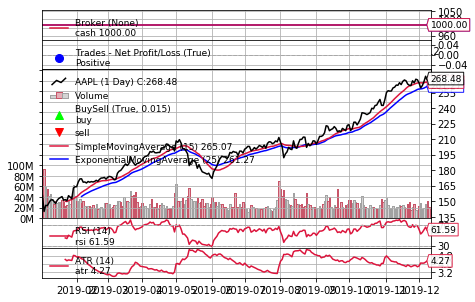

In [10]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        #bt.indicators.WeightedMovingAverage(self.datas[0], period=25,subplot=True)
        #bt.indicators.StochasticSlow(self.datas[0])
        #bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        #bt.indicators.SmoothedMovingAverage(rsi, period=10)
        self.atr = bt.indicators.ATR(self.datas[0])

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            #if self.dataclose[0] > self.sma[0]:
            if self.atr[0] > self.atr[-1]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                #self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.log('BUY CREATE ATR, %.2f' % self.atr[0])
                self.log('Previous ATR: %.2f' % self.atr[-1])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    #modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    #datapath = os.path.join(modpath, '../../datas/orcl-1995-2014.txt')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname='/Users/Ziyi/Desktop/AAPL.csv', 
        fromdate=datetime.datetime(2019, 1, 1), 
        todate=datetime.datetime(2019, 12, 31),
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Plot the result
    cerebro.plot()

In [71]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.long = None
        self.pyramid = 0
        self.previousOrder = None
        self.totalNumberOfOrders = 0
        self.selling = False
        
        # 20 day ATR for N value
        self.atr = bt.indicators.ATR(self.datas[0], period = 20)
        
        # System 1: 20 day entry, 10 day exit
        self.entry = bt.indicators.Highest(period=20)
        self.exit = bt.indicators.Lowest(period=10)
        
        # System 2: 55 day entry, 20 day exit

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                self.previousOrder = order.executed.price
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.entry[-1] < self.dataclose[0]:

                    # BUY, BUY, BUY!!! (with default parameters)
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    self.log('entry high: %.2f' % self.entry[-1])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy()
                    self.selling = False
                    #self.long = True

        else:
            # in the market, see if we can pyramid our position
            if self.pyramid < 5 and self.dataclose[0] > (self.previousOrder + 1/2*self.atr[-1]) and not self.selling:
                # BUY, BUY, BUY!!! (with default parameters)
                self.log('BUY CREATE PYRAMID, current close price: %.2f' % self.dataclose[0])
                self.log('N value: %.2f' % self.atr[-1])
                self.log('Pyramid: %.2f' % self.pyramid)
                self.log('N buy in price: %.2f' % (self.previousOrder + 1/2*self.atr[-1]))
                
                self.pyramid+=1
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
                self.log('New previousOrder, should be same as BUY EXECUTED: %.2f' % self.previousOrder)
                

            # Already in the market ... we might sell
            if self.exit[-1] > self.dataclose[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, 10 day low: %.2f' % self.exit[-1])
                self.log('exit low: %.2f' % self.dataclose[0])
                # Keep track of the created order to avoid a 2nd order
                self.pyramid = 0
                self.order = self.sell()
                self.selling = True
                
            elif self.dataclose[0] < (self.dataclose[-1]-2*self.atr[-1]):
                stopPrice = self.dataclose[-1]-2*self.atr[-1]
                self.log('SELL CREATE, N stop: %.2f' % stopPrice)
                self.log('Current Price: %.2f' % self.dataclose[0])
                self.log('N value: %.2f' % self.atr[-1])
                # Keep track of the created order to avoid a 2nd order
                self.pyramid = 0
                self.order = self.sell()
                self.selling = True


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)


    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname='/Users/Ziyi/Downloads/AAPL.csv', 
         fromdate=datetime.datetime(2019, 1, 1), 
         todate=datetime.datetime(2019, 12, 31),
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)
    
    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2019-01-31, BUY CREATE, 163.98
2019-01-31, entry high: 162.80
2019-02-01, BUY EXECUTED, Price: 164.49, Cost: 1644.90, Comm 1.64
2019-02-04, BUY CREATE PYRAMID, current close price: 168.72
2019-02-04, N value: 4.60
2019-02-04, Pyramid: 0.00
2019-02-04, N buy in price: 166.79
2019-02-04, New previousOrder, should be same as BUY EXECUTED: 164.49
2019-02-05, BUY EXECUTED, Price: 170.30, Cost: 1703.00, Comm 1.70
2019-02-25, BUY CREATE PYRAMID, current close price: 172.39
2019-02-25, N value: 3.48
2019-02-25, Pyramid: 1.00
2019-02-25, N buy in price: 172.04
2019-02-25, New previousOrder, should be same as BUY EXECUTED: 170.30
2019-02-26, BUY EXECUTED, Price: 171.87, Cost: 1718.70, Comm 1.72
2019-03-04, BUY CREATE PYRAMID, current close price: 173.99
2019-03-04, N value: 3.21
2019-03-04, Pyramid: 2.00
2019-03-04, N buy in price: 173.47
2019-03-04, New previousOrder, should be same as BUY EXECUTED: 171.87
2019-03-05, BUY EXECUTED, Price: 174.08, Cost: 1740.8